In [1]:
import pandas as pd
import numpy as np
from datetime import date
import csv 
import requests
import glob
from pandas import DataFrame, concat
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import requests
import os.path, time

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

if 'google.colab' in str(get_ipython()):
  !rm util.py
  !wget https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/util.py

from xgboost import XGBRegressor
from util import select_relevant_rows, select_attributes, read_movement_data, read_multiple_csv,download_updated_mobility_data, download_updated_mobility_data, time_series_cross_validation, train_and_predict, select_time_slot

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

In [3]:
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
    )

In [4]:
frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
    ])

In [5]:
frame_interesting_columns.head()

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,variazione_totale_positivi,nuovi_positivi,deceduti,tamponi,ingressi_terapia_intensiva
4,2020-02-24T18:00:00,10,2,12,0,18,0,148,NaN
25,2020-02-25T18:00:00,15,2,17,8,8,0,391,NaN
46,2020-02-26T18:00:00,20,3,23,20,21,1,577,NaN
67,2020-02-27T18:00:00,36,6,42,50,50,1,1033,NaN
88,2020-02-28T18:00:00,56,6,62,47,48,2,1277,NaN


In [6]:
frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(r'%Y-%m-%d')
frame_interesting_columns = frame_interesting_columns.fillna(0)


In [7]:
# # 'tamponi' is cumulative, revert to incidence
# columns_to_normalize = ['deceduti', 'tamponi']

# for column in columns_to_normalize:
#     frame_interesting_columns[column] = frame_interesting_columns[column].transform(
#         lambda s: s.sub(s.shift().fillna(0)).abs()
#         )


In [8]:
mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
    )

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna'
    )

Data already up to date...


In [9]:
mobility_df = mobility_df[['date',
            'retail_and_recreation_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline',
            'parks_percent_change_from_baseline',
            'transit_stations_percent_change_from_baseline',
            'workplaces_percent_change_from_baseline',
            'residential_percent_change_from_baseline']].fillna(0)

In [10]:
frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date',inplace=True)
mobility_df.set_index('date',inplace=True)
merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
    )
merged = merged.fillna(0)

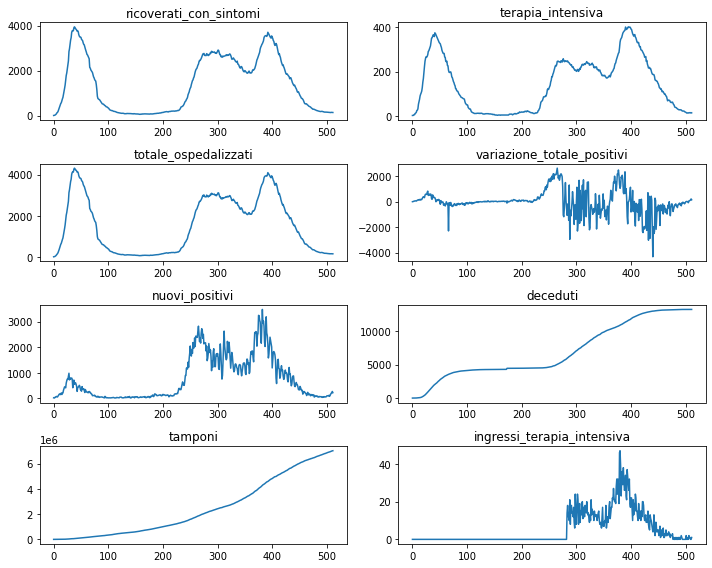

In [11]:
fig, axes = pyplot.subplots(nrows=4,ncols=2,figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(frame_interesting_columns[frame_interesting_columns.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(frame_interesting_columns.columns[i])
    ax.plot()

pyplot.tight_layout()


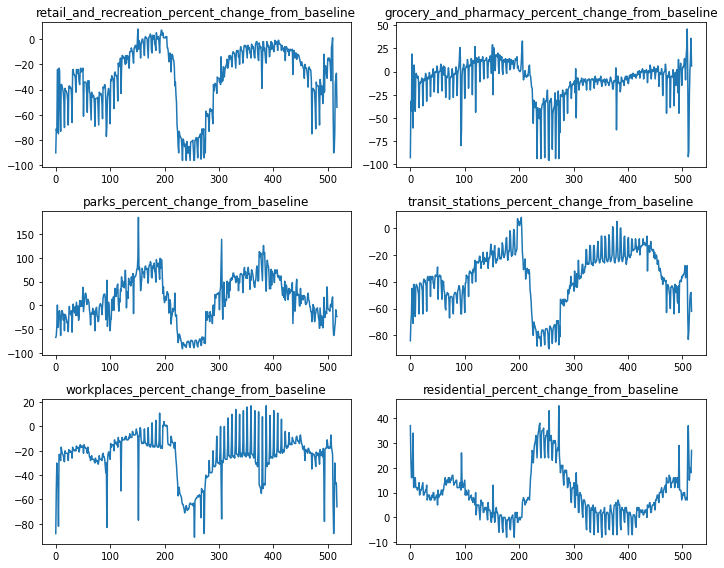

In [12]:
fig, axes = pyplot.subplots(nrows=3,ncols=2,figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(mobility_df[mobility_df.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(mobility_df.columns[i])
    ax.plot()

pyplot.tight_layout()


In [13]:
# try with mobility data
column_to_predict = 'terapia_intensiva'

n_days = 500
n_predictions = 15

y_pred, y_test = train_and_predict(
    merged,
    column_to_predict,
    n_days,
    n_predictions
    )

MAE:  0.4965339660644531


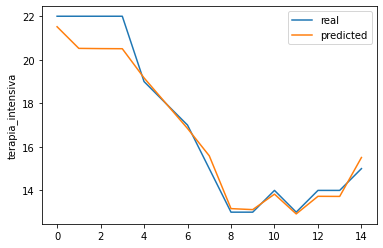

In [14]:
print('MAE: ', mean_absolute_error(y_test, y_pred))
pyplot.plot(y_test.values,label='real')
pyplot.plot(y_pred,label='predicted')
pyplot.ylabel(column_to_predict)
pyplot.legend(loc='best')
pyplot.show()

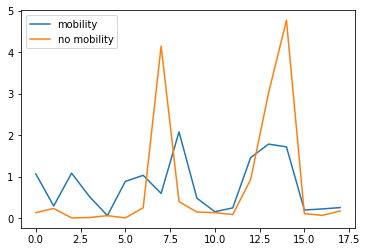

In [15]:
max_window_prediction = 10

column_to_predict = 'terapia_intensiva'

result_with_mobility = time_series_cross_validation(
    merged,
    column_to_predict,
    max_window_prediction
    )
result_without_mobility = time_series_cross_validation(
    frame_interesting_columns,
    column_to_predict,
    max_window_prediction
    )

pyplot.plot(result_with_mobility['mae'],label='mobility')
pyplot.plot(result_without_mobility['mae'],label='no mobility')
pyplot.legend(loc='best')
pyplot.show()

### Results with first order differencing (XGBoost does not handle trends well)

NumExpr defaulting to 4 threads.


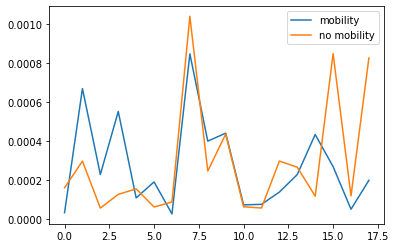

In [16]:
df_diff_mobility = merged.diff().dropna()
df_diff_no_mobility = frame_interesting_columns.diff().dropna()

column_to_predict = 'terapia_intensiva'

max_window_prediction = 10

result_with_mobility = time_series_cross_validation(
    df_diff_mobility,
    column_to_predict,
    max_window_prediction
    )
result_without_mobility = time_series_cross_validation(
    df_diff_no_mobility,
    column_to_predict,
    max_window_prediction
    )

pyplot.plot(result_with_mobility['mae'],label='mobility')
pyplot.plot(result_without_mobility['mae'],label='no mobility')
pyplot.legend(loc='best')
pyplot.show()

MAE:  0.00044753551483154295


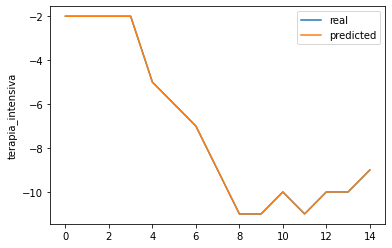

In [17]:
n_days = 300
n_predictions = 15

column_to_predict = 'terapia_intensiva'

y_pred, y_test = train_and_predict(
    df_diff_mobility,
    column_to_predict,
    n_days,
    n_predictions
    )

y_pred = y_pred.cumsum()
y_test = y_test.cumsum()

print('MAE: ', mean_absolute_error(y_test, y_pred))
pyplot.plot(y_test.values,label='real')
pyplot.plot(y_pred,label='predicted')
pyplot.ylabel(column_to_predict)
pyplot.legend(loc='best')
pyplot.show()

MAE:  2.4918563842773436


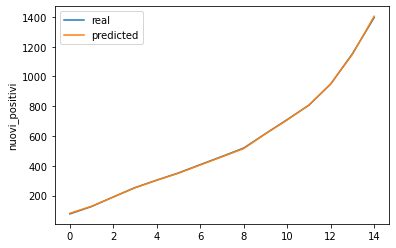

In [18]:
df_date_index = frame_interesting_columns
df_date_index.index = pd.to_datetime(df_date_index.index)

def generate_intances(dataframe,days):
    freq = '%iD' % days
    result = dataframe.groupby(pd.Grouper(level='date',freq=freq)).mean()
    return result

instances = generate_intances(df_date_index,days=2)

n_days = 300
n_predictions = 15

column_to_predict = 'nuovi_positivi'

y_pred, y_test = train_and_predict(
    instances,
    column_to_predict,
    n_days,
    n_predictions
    )

y_pred = y_pred.cumsum()
y_test = y_test.cumsum()

print('MAE: ', mean_absolute_error(y_test, y_pred))
pyplot.plot(y_test.values,label='real')
pyplot.plot(y_pred,label='predicted')
pyplot.ylabel(column_to_predict)
pyplot.legend(loc='best')
pyplot.show()

In [21]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = merged
y = merged[column_to_predict]

tscv = TimeSeriesSplit(n_splits=15,test_size=10,)

print(tscv)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regressor = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000
        )

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=10)
